# Differential Privacy <> TensorFlow for Data Scientist Salaries
https://www.tensorflow.org/responsible_ai/privacy/tutorials/classification_privacy

## Setup Packages

### Install TensorFlow

In [10]:
!pip install tensorflow
!pip install tensorflow-privacy

In [11]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import numpy as np

tf.get_logger().setLevel('ERROR')

import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

Instructions for updating:
non-resource variables are not supported in the long term


### Install Other Libraries

In [162]:
import datetime
from datetime import datetime

from numpy.random import RandomState
import pandas as pd
from sklearn import preprocessing


## Setup Data

### Categorize Salaries

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software Engineer,327000,"Seattle, WA",10.0,1.0,Distributed Systems (Back-End),155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62638,9/13/2018 8:23:32,Microsoft,62,Software Engineer,237000,"Redmond, WA",2.0,2.0,Full Stack,146900.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62639,9/13/2018 14:35:59,MSFT,63,Software Engineer,220000,"Seattle, WA",14.0,12.0,Full Stack,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software Engineer,280000,"San Francisco, CA",8.0,4.0,iOS,194688.0,...,0,0,0,0,0,0,0,0,NaN,NaN


<AxesSubplot:>

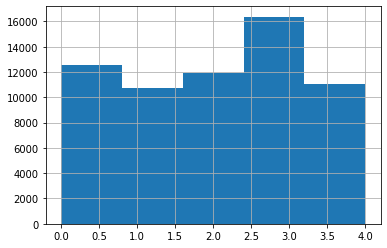

In [229]:
df = pd.read_csv('salaries.csv')
display(df)

# salaryrange
# 0: $0 to $120k
# 1: $120k to $160k
# 2: $160k to $200k
# 3: $200k to $300k
# 4: $300k and beyond
salary_ranges = [0,120000,160000,200000,300000,np.inf]
df['salaryrange'] = pd.cut(df.totalyearlycompensation, salary_ranges, labels=[0,1,2,3,4], include_lowest=True)

df['salaryrange'].hist(bins=len(salary_ranges) - 1)

### Drop Columns

In [230]:
# location information is already encoded as an integer in 'cityid'
df.drop('location', axis=1, inplace=True)

# make model predict without knowledge of the base salary
df.drop('basesalary', axis=1, inplace=True)

# 'otherdetails' column requires NLP to interpret
df.drop('otherdetails', axis=1, inplace=True)

# 'rowNumber' column is unnecessary
df.drop('rowNumber', axis=1, inplace=True)

# education information is entirely encoded in the 'Education' column already
df.drop('Masters_Degree', axis=1, inplace=True)
df.drop('Bachelors_Degree', axis=1, inplace=True)
df.drop('Doctorate_Degree', axis=1, inplace=True)
df.drop('Highschool', axis=1, inplace=True)
df.drop('Some_College', axis=1, inplace=True)

# race information is entirely encoded in the 'Race' column already
df.drop('Race_Asian', axis=1, inplace=True)
df.drop('Race_White', axis=1, inplace=True)
df.drop('Race_Two_Or_More', axis=1, inplace=True)
df.drop('Race_Black', axis=1, inplace=True)
df.drop('Race_Hispanic', axis=1, inplace=True)

display(df)

,timestamp,company,level,title,totalyearlycompensation,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,1.5,1.5,NaN,20000.0,10000.0,NaN,7392,807.0,NaN,NaN,1
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,5.0,3.0,NaN,0.0,0.0,NaN,7419,807.0,NaN,NaN,0
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,8.0,0.0,NaN,0.0,0.0,NaN,11527,819.0,NaN,NaN,4
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,7.0,5.0,NaN,180000.0,35000.0,NaN,7472,807.0,NaN,NaN,4
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,5.0,3.0,NaN,0.0,0.0,NaN,7322,807.0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software Engineer,327000,10.0,1.0,Distributed Systems (Back-End),150000.0,22000.0,NaN,11527,819.0,NaN,NaN,4
62638,9/13/2018 8:23:32,Microsoft,62,Software Engineer,237000,2.0,2.0,Full Stack,73200.0,16000.0,NaN,11521,819.0,NaN,NaN,3
62639,9/13/2018 14:35:59,MSFT,63,Software Engineer,220000,14.0,12.0,Full Stack,25000.0,20000.0,NaN,11527,819.0,NaN,NaN,3
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software Engineer,280000,8.0,4.0,iOS,57000.0,29000.0,NaN,7419,807.0,NaN,NaN,3


### Make All Values Into Integers

In [231]:
# encode timestamp into integers, by year and month
def timestamp_to_int(timestamp):
    dt_obj = datetime.strptime(timestamp.split(' ')[0], '%m/%d/%Y')
    return (100 * dt_obj.year) + (dt_obj.month)

df['timestamp'] = df['timestamp'].apply(timestamp_to_int)

# turn company names to lowercase and encode as integers
df['company'] = df['company'].apply(lambda t: str(t).lower())
df['company'] = pd.Categorical(pd.factorize(df['company'])[0])

# encode level as integer
df['level'] = pd.Categorical(pd.factorize(df['level'])[0])

# encode title as integer
df['title'] = pd.Categorical(pd.factorize(df['title'])[0])

# encode tag as integer
df['tag'] = pd.Categorical(pd.factorize(df['tag'])[0])

# encode gender as integer
df['gender'] = pd.Categorical(pd.factorize(df['gender'])[0])

# encode Race as integer
df['Race'] = pd.Categorical(pd.factorize(df['Race'])[0])

# encode Education as integer
df['Education'] = pd.Categorical(pd.factorize(df['Education'])[0])


### Check Cleaned Data

In [221]:
display(df)

,timestamp,company,level,title,totalyearlycompensation,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
0,201706,0,0,0,127000,1.5,1.5,-1,20000.0,10000.0,-1,7392,807.0,-1,-1,1
1,201706,1,1,1,100000,5.0,3.0,-1,0.0,0.0,-1,7419,807.0,-1,-1,0
2,201706,2,2,0,310000,8.0,0.0,-1,0.0,0.0,-1,11527,819.0,-1,-1,4
3,201706,3,3,2,372000,7.0,5.0,-1,180000.0,35000.0,-1,7472,807.0,-1,-1,4
4,201706,4,4,1,157000,5.0,3.0,-1,0.0,0.0,-1,7322,807.0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,201809,9,88,1,327000,10.0,1.0,1,150000.0,22000.0,-1,11527,819.0,-1,-1,4
62638,201809,4,7,1,237000,2.0,2.0,0,73200.0,16000.0,-1,11521,819.0,-1,-1,3
62639,201809,490,5,1,220000,14.0,12.0,0,25000.0,20000.0,-1,11527,819.0,-1,-1,3
62640,201809,5,30,1,280000,8.0,4.0,10,57000.0,29000.0,-1,7419,807.0,-1,-1,3


### Training/Testing Data

In [241]:
drop_indices = np.random.choice(df.index, len(df.index) % 250, replace=False)
df.drop(drop_indices, inplace=True)

rng = RandomState()

df_train = df.sample(frac=0.7, random_state=rng)
df_test = df.loc[~df.index.isin(df_train.index)]

print('Whole Dataset')
display(df)
print('Training Dataset')
display(df_train)
print('Testing Dataset')
display(df_test)

Whole Dataset


,timestamp,company,level,title,totalyearlycompensation,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
0,201706,0,0,0,127000,1.5,1.5,-1,20000.0,10000.0,-1,7392,807.0,-1,-1,1
1,201706,1,1,1,100000,5.0,3.0,-1,0.0,0.0,-1,7419,807.0,-1,-1,0
2,201706,2,2,0,310000,8.0,0.0,-1,0.0,0.0,-1,11527,819.0,-1,-1,4
3,201706,3,3,2,372000,7.0,5.0,-1,180000.0,35000.0,-1,7472,807.0,-1,-1,4
4,201706,4,4,1,157000,5.0,3.0,-1,0.0,0.0,-1,7322,807.0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,201809,9,88,1,327000,10.0,1.0,1,150000.0,22000.0,-1,11527,819.0,-1,-1,4
62638,201809,4,7,1,237000,2.0,2.0,0,73200.0,16000.0,-1,11521,819.0,-1,-1,3
62639,201809,490,5,1,220000,14.0,12.0,0,25000.0,20000.0,-1,11527,819.0,-1,-1,3
62640,201809,5,30,1,280000,8.0,4.0,10,57000.0,29000.0,-1,7419,807.0,-1,-1,3


Training Dataset


,timestamp,company,level,title,totalyearlycompensation,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
28709,202009,0,336,5,105000,6.0,3.0,1522,30000.0,0.0,1,11527,819.0,-1,-1,0
12462,201910,18,75,1,200000,10.0,1.0,6,0.0,60000.0,-1,7419,807.0,-1,-1,2
27676,202008,1,564,0,210000,4.0,2.0,202,42000.0,16000.0,-1,7422,807.0,-1,-1,3
19304,202004,190,11,1,160000,11.0,7.0,3,88000.0,0.0,0,42498,0.0,-1,1,1
40015,202101,0,91,4,143000,15.0,13.0,10,0.0,43000.0,0,6713,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28102,202008,9,11,1,450000,20.0,14.0,0,200000.0,40000.0,-1,8821,506.0,-1,-1,4
25908,202008,16,112,1,190000,20.0,10.0,7,13000.0,23000.0,1,7434,807.0,1,1,2
10076,201908,23,282,1,190000,15.0,6.0,1,0.0,0.0,-1,7351,807.0,-1,-1,2
30098,202009,37,160,0,325000,15.0,2.0,36,150000.0,0.0,-1,7419,807.0,-1,-1,4


Testing Dataset


,timestamp,company,level,title,totalyearlycompensation,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
4,201706,4,4,1,157000,5.0,3.0,-1,0.0,0.0,-1,7322,807.0,-1,-1,1
11,201707,4,10,1,155000,5.0,3.0,-1,0.0,0.0,-1,11470,819.0,-1,-1,1
12,201707,4,5,0,150000,10.0,10.0,-1,0.0,0.0,-1,11521,819.0,-1,-1,1
13,201707,4,5,1,191000,7.0,7.0,-1,17000.0,22000.0,-1,11527,819.0,-1,-1,2
17,201707,7,14,1,160000,9.0,1.0,-1,0.0,0.0,-1,7419,807.0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62630,201808,4,16,2,250000,7.0,7.0,1,25000.0,45000.0,-1,11527,819.0,-1,-1,3
62634,201809,2,12,1,213000,6.0,4.0,1,38000.0,35000.0,-1,11527,819.0,-1,-1,3
62638,201809,4,7,1,237000,2.0,2.0,0,73200.0,16000.0,-1,11521,819.0,-1,-1,3
62639,201809,490,5,1,220000,14.0,12.0,0,25000.0,20000.0,-1,11527,819.0,-1,-1,3


In [242]:
train_data = df_train.loc[:, df_train.columns != 'salaryrange'].to_numpy()
test_data = df_test.loc[:, df_test.columns != 'salaryrange'].to_numpy()

train_labels = df_train['salaryrange'].to_numpy()
test_labels = df_test['salaryrange'].to_numpy()

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(salary_ranges) - 1)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(salary_ranges) - 1)

## Make the Model

### Set Variables

In [243]:
epochs = 3
batch_size = 250

l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 250
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

### Add Layers to Model

In [244]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(200, activation="relu", input_dim=train_data.shape[1]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(5, activation="linear")
])

In [245]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

In [246]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()
model.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels), batch_size=batch_size)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 200)               3200      
                                                                 
 dense_27 (Dense)            (None, 100)               20100     
                                                                 
 dense_28 (Dense)            (None, 50)                5050      
                                                                 
 dense_29 (Dense)            (None, 5)                 255       
                                                                 
Total params: 28,605
Trainable params: 28,605
Non-trainable params: 0
_________________________________________________________________
Train on 43750 samples, validate on 18750 samples
Epoch 1/3
43750/43750 [==============================] - ETA: 0s - loss: nan - acc: 0.5103

/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


43750/43750 [==============================] - 18s 420us/sample - loss: nan - acc: 0.5103 - val_loss: nan - val_acc: 0.1985
Epoch 2/3
43750/43750 [==============================] - 8s 181us/sample - loss: nan - acc: 0.2020 - val_loss: nan - val_acc: 0.1985
Epoch 3/3
43750/43750 [==============================] - 8s 187us/sample - loss: nan - acc: 0.2020 - val_loss: nan - val_acc: 0.1985


In [247]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.571% and noise_multiplier = 1.3 iterated over 525 steps satisfies differential privacy with eps = 0.639 and delta = 1e-05.
The optimal RDP order is 17.0.


(0.6391718356579965, 17.0)